# 1. Imports

In [3]:
%matplotlib inline
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from collections import Counter
from sklearn.model_selection import train_test_split

from model.tranfAdvModel import SRTransG
from model.discriminatorVITModel import ViTDiscriminator
from model.dataset_manager import load_dataset


from metrics.imageMetrics import compute_quality_loss,compute_metrics_for_model_dataset

from collections import Counter
import pickle
import pyiqa

import time

# 2. Funciones de entrenamiento

In [5]:
# ---------------------------------------------------
# 1. Función para realizar un paso de entrenamiento
def train_step(generator, discriminator, lr_img, hr_img, optimizer_G, optimizer_D,lambda_adv=1e-3, lambda_rec=1, device=None):
    # Generar imagen super-resuelta (SR) a partir de la imagen LR
    sr_img = generator(lr_img)
    
    # Entrenar el Discriminador
    optimizer_D.zero_grad()
    # Upsample de la imagen LR para que coincida con las dimensiones HR
    up_lr = F.interpolate(lr_img, scale_factor=2, mode='bicubic', align_corners=False)
    real_input = torch.cat([up_lr, hr_img], dim=1)  # Concatenar HR real con LR upsampleada -> (B, 6, H, W)
    fake_input = torch.cat([up_lr, sr_img.detach()], dim=1)
    
    real_validity = discriminator(real_input)
    fake_validity = discriminator(fake_input)
    
    valid_labels = torch.ones_like(real_validity)
    fake_labels = torch.zeros_like(fake_validity)
    
    loss_real = F.binary_cross_entropy(real_validity, valid_labels)
    loss_fake = F.binary_cross_entropy(fake_validity, fake_labels)
    loss_D = 0.5 * (loss_real + loss_fake)
    loss_D.backward()
    optimizer_D.step()
    
    # Entrenar el Generador
    optimizer_G.zero_grad()
    fake_input = torch.cat([up_lr, sr_img], dim=1)
    pred_fake = discriminator(fake_input)
    loss_adv = F.binary_cross_entropy(pred_fake, valid_labels)
    #loss_rec_dict = compute_quality_losses(pred=sr_img,target=hr_img,data_range=1.0,device=device,use_psnr=True,use_ssim=False)
    #loss_rec = loss_rec_dict['psnr_loss']
    loss_rec = compute_quality_loss(
        sr_img, hr_img,
        data_range=1.0,
        device=device,
        mode='rgb'  # switch to 'rgb' if needed
    )
    #print(f"loss_rec= {loss_rec}")
    loss_G = lambda_adv * loss_adv + lambda_rec * loss_rec
    loss_G.backward()
    optimizer_G.step()
    
    return loss_G.item(), loss_D.item()


# ---------------------------------------------------
# 1. Función para realizar un paso de entrenamiento
# ---------------------------------------------------
def train_step_OT(generator, lr_img, hr_img, optimizer_G,gen_loss_metric, lambda_adv=2e-3, lambda_rec=1):
    # Generar imagen super-resuelta (SR) a partir de la imagen LR
    sr_img = generator(lr_img)
    
    # Entrenar el Discriminador
    #optimizer_D.zero_grad()
    # Upsample de la imagen LR para que coincida con las dimensiones HR
    up_lr = F.interpolate(lr_img, scale_factor=2, mode='bicubic', align_corners=False)
    #real_input = torch.cat([up_lr, hr_img], dim=1)  # Concatenar HR real con LR upsampleada -> (B, 6, H, W)
    #fake_input = torch.cat([up_lr, sr_img.detach()], dim=1)
    
    #real_validity = discriminator(real_input)
    #fake_validity = discriminator(fake_input)
    
    #valid_labels = torch.ones_like(real_validity)
    #fake_labels = torch.zeros_like(fake_validity)
    
    #loss_real = F.binary_cross_entropy(real_validity, valid_labels)
    #loss_fake = F.binary_cross_entropy(fake_validity, fake_labels)
    #loss_D = 0.5 * (loss_real + loss_fake)
    #loss_D.backward()
    #optimizer_D.step()
    
    # Entrenar el Generador
    optimizer_G.zero_grad()
    #fake_input = torch.cat([up_lr, sr_img], dim=1)
    #pred_fake = discriminator(fake_input)
    #loss_adv = F.binary_cross_entropy(pred_fake, valid_labels)
    if type(gen_loss_metric) is list:
        gen_loss_metric_val = 0
        for loss_metric in gen_loss_metric:
            metric = loss_metric["metric"]
            lambda_metric = loss_metric["lambda"]
            gen_loss_metric_val += metric(sr_img, hr_img)*lambda_metric
        loss_rec = 1 - gen_loss_metric_val
    else:
        loss_rec = 1 - gen_loss_metric(sr_img, hr_img)
    loss_G = loss_rec
    loss_G.backward()
    optimizer_G.step()
    
    return loss_G.item()

In [6]:
# ---------------------------------------------------
# 2. Funcion para entrenar el modelo
# ---------------------------------------------------
def train_model_with_metrics(
    train_loader,
    gen_kwargs,
    disc_kwargs,
    num_epochs=2,   
    lr_rate=2e-4,
    model_save_dir=".",
    max_train_time=None,
    start_epoch=-1,
    generator=None,
    discriminator=None,
    optimizer_G=None,
    optimizer_D=None,
    history=None
):
    """
    Entrena el modelo y, al final de cada época, calcula el PSNR y SSIM,
    guarda modelos y detiene el entrenamiento si se supera max_train_time.

    Args:
        train_loader (DataLoader): DataLoader con pares (LR, HR).        
        num_epochs (int): Número máximo de épocas.        
        gen_kwargs (dict): Parámetros del modelo generador.
        disc_kwargs (dict): Parámetros del modelo discriminador.
        model_save_dir (str): Directorio donde guardar los pesos del modelo.
        test_count (int): Número de imágenes de prueba a guardar.
        max_train_time (float): Tiempo máximo total de entrenamiento en segundos.

    Returns:
        generator, discriminator, optimizer_G, optimizer_D, history    
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     # 1) Si no se pasan modelos/optimizadores, creamos nuevos
    if generator is None:
        generator = SRTransG(**gen_kwargs).to(device)
    if discriminator is None:
        discriminator = ViTDiscriminator(**disc_kwargs).to(device)
    if optimizer_G is None:
        optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate)
    if optimizer_D is None:
        optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_rate)

    # 2) Inicializar historial si es necesario
    if history is None:
        history = {"loss_G": [], "loss_D": [], "PSNR": [], "SSIM": []}
    
    
    generator.train()
    discriminator.train()

    start_total = time.time()
    if start_epoch<0:
        start_epoch=0
        
        
    for epoch in range(start_epoch, num_epochs):                
        epoch_start = time.time()
        
        epoch_loss_G = 0.0
        epoch_loss_D = 0.0
        num_batches = 0
        for lr_imgs, hr_imgs in train_loader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            loss_G, loss_D = train_step(generator=generator, discriminator=discriminator, lr_img=lr_imgs, hr_img=hr_imgs, optimizer_G=optimizer_G,
                                        optimizer_D=optimizer_D, device=device)
            epoch_loss_G += loss_G
            epoch_loss_D += loss_D
            num_batches += 1
        avg_loss_G = epoch_loss_G / num_batches
        avg_loss_D = epoch_loss_D / num_batches

        #avg_psnr, avg_ssim = evaluate_dataset(generator, train_loader, device)  #Calcular métricas sobre todo el dataset usando el mismo DataLoader

        per_channel = True
        
        metrics_dict = compute_metrics_for_model_dataset(generator, train_loader, 1.0, device, per_channel=per_channel) 
        if per_channel:
            avg_psnr = metrics_dict["psnr_overall_mean"]
            avg_ssim = metrics_dict["ssim_overall_mean"]
        else:
            avg_psnr = metrics_dict["psnr"]
            avg_ssim = metrics_dict["ssim"]
        
        
        history["loss_G"].append(avg_loss_G)
        history["loss_D"].append(avg_loss_D)
        history["PSNR"].append(avg_psnr.item())
        history["SSIM"].append(avg_ssim.item())
        
        elapsed = time.time() - epoch_start
        mins, secs = divmod(int(elapsed), 60)
        total_elapsed = time.time() - start_total
        t_m, t_s = divmod(int(total_elapsed), 60)
        m, s = divmod(int(elapsed), 60)
        print(f"Época {epoch+1}/{num_epochs} - Gen: {avg_loss_G:.4f}, Dis: {avg_loss_D:.4f}, PSNR: {avg_psnr:.2f}dB, SSIM: {avg_ssim:.4f}, "
              f"Tiempos -> Época: {mins}m{secs}s, Total: {t_m}m{t_s}s")
        

        torch.save(generator.state_dict(), model_save_dir+"generator_EP"+ "{:02d}".format(epoch+1)  +".pth")
        #torch.save(discriminator.state_dict(), model_save_dir+"discriminator_EP"+ "{:02d}".format(epoch+1) +".pth")

        # 3) Guardar un checkpoint si se finaliza el entrenamiento por falta de tiempo
        if max_train_time and (time.time() - start_total) > max_train_time:
            print(f"Entrenamiento detenido: tiempo total {time.time() - start_total:.2f}s excede el máximo de {max_train_time}s")
            checkpoint = {
            "epoch": epoch,
            "generator": generator.state_dict(),
            "discriminator": discriminator.state_dict(),
            "opt_G": optimizer_G.state_dict(),
            "opt_D": optimizer_D.state_dict(),
            "history": history,
            "elapsed": elapsed
            }
            torch.save(checkpoint, os.path.join(model_save_dir, "checkpoint.pth"))
            break
        

        generator.train()
    
    return generator, discriminator,optimizer_G,optimizer_D, history, epoch


def train_model_with_metrics_onlyTransformer(
    train_loader,
    hr_size,
    num_epochs=2,
    patch_size=16,
    embed_dim=16,
    token_dim=512,    
    lr_rate=2e-4,
    model_save_dir=".",
    max_train_time=None,
    start_epoch=-1,
    generator=None,
    optimizer_G=None,
    history=None
):
    """
    Entrena el modelo y, al final de cada época, calcula el PSNR y SSIM,
    guarda modelos y detiene el entrenamiento si se supera max_train_time.

    Args:
        train_loader (DataLoader): DataLoader con pares (LR, HR).
        hr_size (tuple[int]): Dimensiones de la imagen HR.
        num_epochs (int): Número máximo de épocas.
        patch_size (int): Tamaño de cada parche.
        embed_dim (int): Número de canales tras la capa inicial.
        token_dim (int): Dimensión para la proyección de tokens.
        lr_rate (float): Tasa de aprendizaje.
        model_save_dir (str): Directorio donde guardar los pesos del modelo.
        test_count (int): Número de imágenes de prueba a guardar.
        max_train_time (float): Tiempo máximo total de entrenamiento en segundos.

    Returns:
        generator, discriminator, optimizer_G, optimizer_D, history    
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     # 1) Si no se pasan modelos/optimizadores, creamos nuevos
    if generator is None:
        generator = SRTransG(embed_dim, patch_size=patch_size, token_dim=token_dim, num_levels=3, num_refinement=1,
                             encoder_transformer_blocks=[4,6,6],
                             decoder_transformer_blocks=[4,4,6],
                             refinement_transformer_blocks=[4]).to(device)
    if optimizer_G is None:
        optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate)

    # 2) Inicializar historial si es necesario
    if history is None:
        history = {"loss_G": [], "PSNR": [], "SSIM": []}    
    
    generator.train()
    
    ssimc_loss_metric = pyiqa.create_metric('ssimc', device=device, as_loss=True)
    psnr_loss_metric = pyiqa.create_metric('psnr', device=device, as_loss=True)

    loss_metrics = []
    loss_metrics.append({"metric":ssimc_loss_metric,"lambda": 0.7})
    loss_metrics.append({"metric":psnr_loss_metric,"lambda": 0.3})

    start_total = time.time()
    if start_epoch<0:
        start_epoch=0
        
        
    for epoch in range(start_epoch, num_epochs):                
        epoch_start = time.time()
        
        epoch_loss_G = 0.0
        num_batches = 0
        for lr_imgs, hr_imgs in train_loader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            loss_G = train_step_OT(generator, lr_imgs, hr_imgs, optimizer_G,loss_metrics)
            epoch_loss_G += loss_G
            num_batches += 1
        avg_loss_G = epoch_loss_G / num_batches
                
        avg_psnr, avg_ssim = evaluate_dataset(generator, train_loader, device)  #Calcular métricas sobre todo el dataset usando el mismo DataLoader

        history["loss_G"].append(avg_loss_G)
        history["PSNR"].append(avg_psnr)
        history["SSIM"].append(avg_ssim)
        
        elapsed = time.time() - epoch_start
        mins, secs = divmod(int(elapsed), 60)
        total_elapsed = time.time() - start_total
        t_m, t_s = divmod(int(total_elapsed), 60)
        m, s = divmod(int(elapsed), 60)
        print(f"Época {epoch+1}/{num_epochs} - Gen: {avg_loss_G:.4f}, PSNR: {avg_psnr:.2f}dB, SSIM: {avg_ssim:.4f}, "
              f"Tiempos -> Época: {mins}m{secs}s, Total: {t_m}m{t_s}s")
        

        torch.save(generator.state_dict(), model_save_dir+"generator_EP"+ "{:02d}".format(epoch+1)  +".pth")
        
        # 3) Guardar un checkpoint si se finaliza el entrenamiento por falta de tiempo
        if max_train_time and (time.time() - start_total) > max_train_time:
            print(f"Entrenamiento detenido: tiempo total {time.time() - start_total:.2f}s excede el máximo de {max_train_time}s")
            checkpoint = {
            "epoch": epoch,
            "generator": generator.state_dict(),
            "opt_G": optimizer_G.state_dict(),
            "history": history,
            "elapsed": elapsed
            }
            torch.save(checkpoint, os.path.join(model_save_dir, "checkpoint.pth"))
            break
        

        generator.train()
    
    return generator,optimizer_G, history, epoch


In [7]:
# ---------------------------------------------------
# 2. Función para cargar el dataset (almacenado en RAM)
# ---------------------------------------------------
def load_dataset_old(
    hr_dir: str,
    lr_dir: str,
    suffix: str,
    hr_size: tuple,
    max_images: int = 100,
    val_frac: float = 0.1
):
    """
    Carga y valida imágenes HR/LR, y las separa en train/val.

    Args:
        hr_dir (str): Carpeta con imágenes HR.
        lr_dir (str): Carpeta con imágenes LR.
        suffix (str): Sufijo que distingue LR de HR (ej. 'x2').
        hr_size (tuple): (alto, ancho) esperado en HR.
        max_images (int): Si >0, número máximo de pares a usar. Si =0, usar todas.
        val_frac (float): Fracción [0,1) de imágenes para validación.

    Returns:
        train_dataset (TensorDataset), val_dataset (TensorDataset),
        train_names (list[str]), val_names (list[str])
    """

    # 1) Listamos y filtramos todas las HR que tienen EXACTAMENTE hr_size:
    all_hr = [f for f in sorted(os.listdir(hr_dir))
              if f.lower().endswith(('.png','.jpg','.jpeg'))]
    valid_hr = []
    for fn in all_hr:
        with Image.open(os.path.join(hr_dir, fn)) as im:
            if im.size == (hr_size[1], hr_size[0]):
                valid_hr.append(fn)
    total_hr = len(valid_hr)

    # 2) Chequeo de cantidad:
    if max_images > 0 and total_hr < max_images:
        raise RuntimeError(
            f"Sólo hay {total_hr} imágenes HR con resolución {hr_size}, "
            f"pero se pidió max_images={max_images}."
        )
    if max_images == 0:
        max_images = total_hr

    # 3) Seleccionamos aleatoriamente max_images nombres de HR:
    selected_hr = valid_hr[:max_images]
    
    # 4) Validamos que exista LR con sufijo y tamaño = hr_size//2:
    lr_names = []
    for hr_fn in selected_hr:
        base, _ = os.path.splitext(hr_fn)
        lr_fn = base + suffix + os.path.splitext(hr_fn)[1]
        lr_path = os.path.join(lr_dir, lr_fn)
        if not os.path.exists(lr_path):
            raise RuntimeError(f"No existe LR para '{hr_fn}' → buscado '{lr_fn}'.")
        with Image.open(lr_path) as im:
            expected = (hr_size[1]//2, hr_size[0]//2)
            if im.size != expected:
                raise RuntimeError(
                    f"LR '{lr_fn}' tiene tamaño {im.size}, "
                    f"pero esperaba {expected}."
                )
        lr_names.append(lr_fn)

    # 5) Dividimos nombres en train / val:
    train_hr, val_hr, train_lr, val_lr = train_test_split(
        selected_hr, lr_names,
        test_size=val_frac, random_state=42
    )

    # 6) Transform a tensor (sin resize, ya están en tamaño correcto)
    to_tensor = transforms.ToTensor()
    def make_dataset(hr_list, lr_list):
        hr_tensors, lr_tensors = [], []
        for hr_fn, lr_fn in zip(hr_list, lr_list):
            hr = Image.open(os.path.join(hr_dir, hr_fn)).convert('RGB')
            lr = Image.open(os.path.join(lr_dir, lr_fn)).convert('RGB')
            hr_tensors.append(to_tensor(hr))
            lr_tensors.append(to_tensor(lr))
        return torch.stack(lr_tensors), torch.stack(hr_tensors)

    lr_train, hr_train = make_dataset(train_hr, train_lr)
    lr_val,   hr_val   = make_dataset(val_hr,   val_lr)

    train_dataset = TensorDataset(lr_train, hr_train)
    val_dataset   = TensorDataset(lr_val,   hr_val)

    return train_dataset, val_dataset, train_hr, val_hr

def make_loader_from_split(pickle_path,
                           hr_dir, lr_dir,
                           suffix="x2", hr_size=(128,128)):
    """
    Reconstruye los DataLoaders de entrenamiento y validación a partir
    de un pickle con las listas de splits, y devuelve además esas listas.

    Args:
        pickle_path (str): Ruta al pickle con {'train': [...], 'val': [...]}.
        hr_dir (str): Carpeta con imágenes HR.
        lr_dir (str): Carpeta con imágenes LR.
        suffix (str): Sufijo de las LR.
        hr_size (tuple): Tamaño deseado de las HR.
        batch_size (int): Tamaño de batch.
        shuffle (bool): Si barajar el set de entrenamiento.
        num_workers (int): Número de workers para DataLoader.

    Returns:
        train_loader (DataLoader): DataLoader de entrenamiento.
        val_loader (DataLoader): DataLoader de validación.
        train_hr (List[str]): Lista de nombres base del split de entrenamiento.
        val_hr (List[str]): Lista de nombres base del split de validación.
    """
    # Cargamos las listas de nombres desde el pickle
    with open(pickle_path, "rb") as f:
        split = pickle.load(f)
    train_hr = split["train"]
    val_hr   = split["val"]


    to_tensor = transforms.ToTensor()
    def make_dataset(hr_list):
        hr_tensors, lr_tensors = [], []
        for hr_fn in hr_list:
            lr_fn = hr_fn.replace(".png", suffix+".png")
            hr = Image.open(os.path.join(hr_dir, hr_fn)).convert('RGB')
            lr = Image.open(os.path.join(lr_dir, lr_fn)).convert('RGB')
            hr_tensors.append(to_tensor(hr))
            lr_tensors.append(to_tensor(lr))
        return torch.stack(lr_tensors), torch.stack(hr_tensors)


    lr_train, hr_train = make_dataset(train_hr)
    lr_val,   hr_val   = make_dataset(val_hr)
    
    train_dataset = TensorDataset(lr_train, hr_train)
    val_dataset   = TensorDataset(lr_val,   hr_val)

    return train_dataset, val_dataset, train_hr, val_hr

# 5. Entrenamiento con imagenes satelitales (Adversarial)

In [9]:
# ---------------------------------------------------
# 1. Definimos los directorios donde estan los dataset de entrada y los directorios de salida
# ---------------------------------------------------

dataset_dir= "Datasets/"

output_dir= "G:/MaestriaInformatica/Tesis/Outputs/TransfAdv_Sat/"

hr_train_dir = dataset_dir +"SatImages/perusat_v5_rgb/HR/"
lr_train_dir = dataset_dir +"SatImages/perusat_v5_rgb/LR_BICUBIC/X2/"
suffix = "_x2" 
hr_size=(512,512)
max_images = 0
val_frac = 0.20

sample_test_output_dir = output_dir + "Sat_sample_gen/"
model_save_dir = output_dir + "models/" 

num_epochs = 150

# Parámetros de tu modelo
gen_kwargs = dict(
    input_dim=3,
    embed_dim=16,
    patch_size=64,
    token_dim = 512,
    num_levels=3, 
    num_refinement=1,
    encoder_transformer_blocks=[4,6,6],
    decoder_transformer_blocks=[4,4,6],
    refinement_transformer_blocks=[4]
)

disc_kwargs = dict(
    hr_size=hr_size,
    in_channels=gen_kwargs["input_dim"]*2,
    patch_size=16,
    embed_dim=64,
    depth=6,
    num_heads=4, 
    mlp_ratio=4
)

lr_rate = 4e-5

if not(os.path.exists(model_save_dir)):
    os.makedirs(model_save_dir, exist_ok = True)

if not(os.path.exists(sample_test_output_dir)):
    os.makedirs(sample_test_output_dir, exist_ok = True)

In [10]:
# ---------------------------------------------------
# 2. Configuración del DataLoader
# ---------------------------------------------------
#splits_pkl = os.path.join(model_save_dir, "splits.pkl")
if True:
    splits_pkl = os.path.join(model_save_dir, "splits.pkl")
    print("Cargando splits desde archivo")
    if os.path.exists(splits_pkl):    
        train_dataset, val_dataset, train_hr, val_hr = make_loader_from_split(
            splits_pkl,
            hr_train_dir, lr_train_dir,
            suffix="_x2", hr_size=(512,512)
        )
        # Crear DataLoader (batch size pequeño para ahorrar memoria)
        batch_size = 1
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
    else:
        # Llamar a la función de carga, pasando el sufijo deseado
        train_dataset, val_dataset, train_hr, val_hr = load_dataset(hr_train_dir, lr_train_dir, suffix=suffix, max_images=max_images, hr_size=hr_size, val_frac=val_frac)
        #train_dataset, val_dataset, train_hr, val_hr = load_dataset(hr_train_dir, lr_train_dir, suffix=suffix, max_images=400, hr_size=hr_size, val_frac=val_frac)
        
        # Crear DataLoader (batch size pequeño para ahorrar memoria)
        batch_size = 1
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    lr_all, hr_all = train_loader.dataset.tensors
    
    print("Dataset HR (CPU):", hr_all.shape)
    print("Dataset LR (CPU):", lr_all.shape)

else:
    # ---------------------------------------------------
    splits_pkl = os.path.join(model_save_dir, "splits.pkl")
    train_dataset, val_dataset, train_hr, val_hr, _ = load_dataset(hr_train_dir, lr_train_dir, suffix=suffix, max_images=400, hr_size=hr_size, val_frac=val_frac, pickle_path=None)
    
    # Crear DataLoader (batch size pequeño para ahorrar memoria)
    batch_size = 1
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    lr_all, hr_all = train_loader.dataset.tensors
    
    print("Dataset HR (CPU):", hr_all.shape)
    print("Dataset LR (CPU):", lr_all.shape)

Cargando splits desde archivo
Dataset HR (CPU): torch.Size([2349, 3, 512, 512])
Dataset LR (CPU): torch.Size([2349, 3, 256, 256])


In [11]:
# ---------------------------------------------------
# 3. Entremiento del modelo
# ---------------------------------------------------

checkpoint_path = os.path.join(model_save_dir, "checkpoint.pth")

if os.path.exists(checkpoint_path):
    print("Checkpoint encontrado: reanudando entrenamiento.")
    ckpt = torch.load(checkpoint_path, map_location="cpu")
    start_epoch = ckpt["epoch"] + 1
    history = ckpt["history"]
    elapsed_prev = ckpt["elapsed"]
     # Recrear modelos y optimizadores
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    generator = SRTransG(**gen_kwargs).to(device)
    discriminator = ViTDiscriminator(**disc_kwargs).to(device)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

    # Cargar estados
    generator.load_state_dict(ckpt["generator"])
    discriminator.load_state_dict(ckpt["discriminator"])
    optimizer_G.load_state_dict(ckpt["opt_G"])
    optimizer_D.load_state_dict(ckpt["opt_D"])

else: 
    print("Sin checkpoint: comenzando desde cero.")
    start_epoch = -1
    history = None
    elapsed_prev = 0.0
    generator = discriminator = optimizer_G = optimizer_D = None
    
# Iniciamos el entrenamiento
generator, discriminator, optimizer_G, optimizer_D, history, last_epoch = train_model_with_metrics(
    train_loader,
    num_epochs=num_epochs,
    gen_kwargs=gen_kwargs,
    disc_kwargs=disc_kwargs,    
    model_save_dir=model_save_dir,
    max_train_time = 7200,
    start_epoch=start_epoch,
    generator=generator,
    discriminator=discriminator,
    optimizer_G=optimizer_G,
    optimizer_D=optimizer_D,
    history=history)


if True:
    #guardamos la lista de nombres de las imagenes que estan en el grupo de entrenamiento y las del grupo de validaciónn
    with open( model_save_dir+"splits.pkl", "wb") as f:
        pickle.dump({"train": train_hr, "val": val_hr}, f)
    
    #guardamos el historial de looses, PSNR y SSIM
    with open( model_save_dir+"history.pkl", "wb") as f:
        pickle.dump({"history": history}, f)
    
    # guardamos los modelos
    os.makedirs(model_save_dir, exist_ok = True) 
    torch.save(generator.state_dict(), model_save_dir+"generator.pth")
    #torch.save(discriminator.state_dict(), model_save_dir+"discriminator.pth")

Checkpoint encontrado: reanudando entrenamiento.


C:\Users\victo\AppData\Local\Temp\ipykernel_48540\2875831749.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location="cpu")
G:\an

Época 21/150 - Gen: 0.8590, Dis: 0.0000, PSNR: 18.56dB, SSIM: 0.5292, Tiempos -> Época: 5m54s, Total: 5m54s
Época 22/150 - Gen: 0.6883, Dis: 0.0000, PSNR: 24.08dB, SSIM: 0.4955, Tiempos -> Época: 6m5s, Total: 12m2s
Época 23/150 - Gen: 0.2033, Dis: 0.0000, PSNR: 28.05dB, SSIM: 0.7451, Tiempos -> Época: 6m0s, Total: 18m4s
Época 24/150 - Gen: 0.0918, Dis: 0.0296, PSNR: 28.19dB, SSIM: 0.8112, Tiempos -> Época: 5m58s, Total: 24m5s
Época 25/150 - Gen: 0.1060, Dis: 0.0257, PSNR: 29.49dB, SSIM: 0.8315, Tiempos -> Época: 5m58s, Total: 30m6s
Época 26/150 - Gen: 1029.1037, Dis: 0.0094, PSNR: 17.68dB, SSIM: 0.4687, Tiempos -> Época: 5m58s, Total: 36m6s
Época 27/150 - Gen: 0.6159, Dis: 0.0018, PSNR: 19.38dB, SSIM: 0.4745, Tiempos -> Época: 5m58s, Total: 42m7s
Época 28/150 - Gen: 0.3039, Dis: 0.0001, PSNR: 28.53dB, SSIM: 0.7607, Tiempos -> Época: 6m6s, Total: 48m16s
Época 29/150 - Gen: 0.0990, Dis: 0.0281, PSNR: 30.02dB, SSIM: 0.8112, Tiempos -> Época: 5m59s, Total: 54m18s
Época 30/150 - Gen: 1672.7

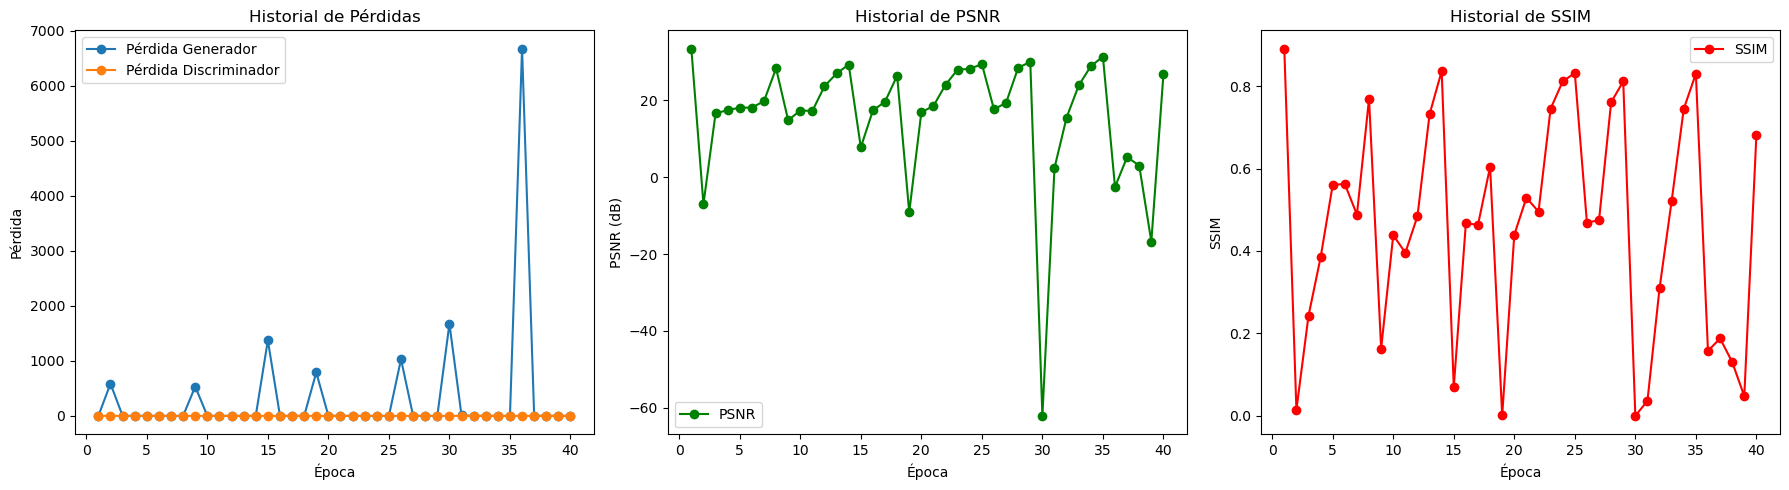

In [12]:
# ---------------------------------------------------
# 3. Evaluación: Mostramos la evolución de nuestros indicadores
# ---------------------------------------------------
epochs = range(1, len(history["loss_G"]) + 1)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(epochs, history["loss_G"], label="Pérdida Generador", marker="o")
plt.plot(epochs, history["loss_D"], label="Pérdida Discriminador", marker="o")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Historial de Pérdidas")
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, history["PSNR"], label="PSNR", marker="o", color="green")
plt.xlabel("Época")
plt.ylabel("PSNR (dB)")
plt.title("Historial de PSNR")
plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, history["SSIM"], label="SSIM", marker="o", color="red")
plt.xlabel("Época")
plt.ylabel("SSIM")
plt.title("Historial de SSIM")
plt.legend()

plt.tight_layout()
plt.show()

# 6. Entrenamiento con imagenes satelitales (Transformers)

In [ ]:
# ---------------------------------------------------
# 1. Definimos los directorios donde estan los dataset de entrada y los directorios de salida
# ---------------------------------------------------

dataset_dir= "Datasets/"

output_dir= "G:/MaestriaInformatica/Tesis/Outputs/Transf/"

hr_train_dir = dataset_dir +"SatImages/perusat_v5_rgb/HR/"
lr_train_dir = dataset_dir +"SatImages/perusat_v5_rgb/LR_BICUBIC/X2/"
suffix = "_x2" 
hr_size=(512,512)
max_images = 0
val_frac = 0.20

sample_test_output_dir = output_dir + "Sat_sample_gen/"
model_save_dir = output_dir + "models/" 

num_epochs = 84
patch_size = 64
embed_dim = 16
token_dim = 512
lr_rate = 4e-5

if not(os.path.exists(model_save_dir)):
    os.makedirs(model_save_dir, exist_ok = True)

if not(os.path.exists(sample_test_output_dir)):
    os.makedirs(sample_test_output_dir, exist_ok = True)

In [ ]:
# ---------------------------------------------------
# 2. Configuración del DataLoader
# ---------------------------------------------------
splits_pkl = os.path.join(model_save_dir, "splits.pkl")
if os.path.exists(splits_pkl):    
    print("Cargando splits desde archivo")
    train_dataset, val_dataset, train_hr, val_hr = make_loader_from_split(
        splits_pkl,
        hr_train_dir, lr_train_dir,
        suffix="_x2", hr_size=(512,512)
    )
    # Crear DataLoader (batch size pequeño para ahorrar memoria)
    batch_size = 1
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
else:
    # Llamar a la función de carga, pasando el sufijo deseado
    train_dataset, val_dataset, train_hr, val_hr = load_dataset(hr_train_dir, lr_train_dir, suffix=suffix, max_images=max_images, hr_size=hr_size, val_frac=val_frac)
    
    # Crear DataLoader (batch size pequeño para ahorrar memoria)
    batch_size = 1
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

lr_all, hr_all = train_loader.dataset.tensors

print("Dataset HR (CPU):", hr_all.shape)
print("Dataset LR (CPU):", lr_all.shape)

In [ ]:
# ---------------------------------------------------
# 3. Entremiento del modelo
# ---------------------------------------------------

checkpoint_path = os.path.join(model_save_dir, "checkpoint.pth")

if os.path.exists(checkpoint_path):
    print("Checkpoint encontrado: reanudando entrenamiento.")
    ckpt = torch.load(checkpoint_path, map_location="cpu")
    start_epoch = ckpt["epoch"] + 1
    history = ckpt["history"]
    elapsed_prev = ckpt["elapsed"]
     # Recrear modelos y optimizadores
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    generator = SRTransG(embed_dim, patch_size=patch_size, token_dim=token_dim, num_levels=3, num_refinement=1,
                             encoder_transformer_blocks=[4,6,6],
                             decoder_transformer_blocks=[4,4,6],
                             refinement_transformer_blocks=[4]).to(device)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4)

    # Cargar estados
    generator.load_state_dict(ckpt["generator"])
    optimizer_G.load_state_dict(ckpt["opt_G"])

else: 
    print("Sin checkpoint: comenzando desde cero.")
    start_epoch = -1
    history = None
    elapsed_prev = 0.0
    generator = optimizer_G = None
    
# Iniciamos el entrenamiento
generator, optimizer_G, history, last_epoch = train_model_with_metrics_onlyTransformer(
    train_loader,
    hr_size,
    num_epochs=num_epochs,
    patch_size=patch_size,
    embed_dim=embed_dim,
    token_dim=token_dim,
    lr_rate=lr_rate,
    model_save_dir=model_save_dir,
    max_train_time = 18000,
    start_epoch=start_epoch,
    generator=generator,
    optimizer_G=optimizer_G,
    history=history)


#guardamos la lista de nombres de las imagenes que estan en el grupo de entrenamiento y las del grupo de validaciónn
with open( model_save_dir+"splits.pkl", "wb") as f:
    pickle.dump({"train": train_hr, "val": val_hr}, f)

#guardamos el historial de looses, PSNR y SSIM
with open( model_save_dir+"history.pkl", "wb") as f:
    pickle.dump({"history": history}, f)

# guardamos los modelos
os.makedirs(model_save_dir, exist_ok = True) 
torch.save(generator.state_dict(), model_save_dir+"generator.pth")

import torch

# Load the pth file (don't put map_location if using GPU)
checkpoint = torch.load("G:/MaestriaInformatica/Tesis/Outputs/TransfAdv_Sat/models/generator_EP84.pth", map_location="cpu")

# Print type of object
print(type(checkpoint))

# If it's a dict (common case), print its keys
if isinstance(checkpoint, dict):
    print("Top-level keys:", checkpoint.keys())

    # Optional: peek into each key
    for k in checkpoint:
        print(f"Key: {k} → Type: {type(checkpoint[k])}")
        # If it's a state_dict, print number of parameters
        if isinstance(checkpoint[k], dict):
            print("  Sample nested keys:", list(checkpoint[k].keys())[:5])
else:
    print("Not a dict — possibly a full model object.")
